# Plant Disease Classification with Labeled Data

## Project Description

This project focuses on **plant disease classification** using the **PlantVillage dataset** from Kaggle.  
A deep learning model is trained on labeled leaf images to accurately identify different plant diseases.

### Include Libraries

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path  
import pandas as pd       
from sklearn.model_selection import train_test_split 
from tensorflow.keras.regularizers import l2

### 1. Setting Parameters

In [5]:
DATA_DIR = "PlantVillage/"  # Main folder path
IMG_SIZE = (128, 128)       # Image Dimension
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2      # %20 for validation

# create a trusted path object
DATA_PATH_OBJECT = Path(DATA_DIR).resolve()

# Check
if not DATA_PATH_OBJECT.is_dir():
    print(f"HATA: '{DATA_PATH_OBJECT}' mutlak yolu bulunamadı. Lütfen yolu kontrol edin.")
    exit()


### 2. Create Dataframe

In [6]:
filepaths = []
labels = []

# Browse through each class folder
for class_folder in DATA_PATH_OBJECT.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name

        # Collect images from class folder (Include *.JPG ve *.jpg)
        for image_path in class_folder.glob('*.[Jj][Pp][Gg]'):
            filepaths.append(str(image_path))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

class_names = df['label'].unique().tolist()
NUM_CLASSES = len(class_names)
INPUT_SHAPE = IMG_SIZE + (3,)

print(f"All Folder: {len(df)}")
print(f"Percieved Class Number: {NUM_CLASSES}")

All Folder: 20636
Percieved Class Number: 15


### 3. Split the Datasets (Train and Validation)

In [7]:
# Split datasets with Stratify=True for distribution of classes
train_df, val_df = train_test_split(
    df,
    test_size=VALIDATION_SPLIT,
    shuffle=True,
    random_state=42,
    stratify=df['label']
)

### 4. Preprocessing and Loading with Data Generator

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizasyon
    rotation_range=20,          # Görüntüleri rastgele 20 dereceye kadar döndür
    width_shift_range=0.1,      # Görüntüleri yatayda %10 kaydır
    height_shift_range=0.1,     # Görüntüleri dikeyde %10 kaydır
    zoom_range=0.1,             # %10'a kadar rastgele yakınlaştırma yap
    horizontal_flip=True,       # Yatay çevirme yap
    fill_mode='nearest'         # Yeni pikselleri en yakın değerle doldur
)

# Loading training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Loading training data
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


train_ds = train_generator
val_ds = val_generator

Found 16508 validated image filenames belonging to 15 classes.
Found 4128 validated image filenames belonging to 15 classes.


### 5. Create CNN Model

In [19]:
def create_basic_cnn_model(input_shape, num_classes):
    model = Sequential([
        # 1. Convolutional Layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        # 2. Convolutional Layer
        Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        
        # 3. Convolutional Layer
        Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        
        # Flatten
        Flatten(),
        
        # Fully Connected (Dense) Layers
        Dense(512, activation='relu'),
        Dropout(0.5), 
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_basic_cnn_model(INPUT_SHAPE, NUM_CLASSES)

# Compiling
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("\n--- Model Özeti ---")
model.summary()

# --- 6. Training Model ---
EPOCHS = 10
print(f"\n--- Model Eğitimi Başlıyor ({EPOCHS} Epoch) ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)




--- Model Özeti ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,511 (49.39 MB)

 Trainable params: 12,946,511 (49.39 MB)

 Non-trainable params: 0 (0.00 B)


--- Model Eğitimi Başlıyor (10 Epoch) ---
Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 232s 447ms/step - accuracy: 0.5630 - loss: 1.3956 - val_accuracy: 0.7737 - val_loss: 0.7538
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 226s 438ms/step - accuracy: 0.7332 - loss: 0.8463 - val_accuracy: 0.8069 - val_loss: 0.6293
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 229s 444ms/step - accuracy: 0.7803 - loss: 0.7088 - val_accuracy: 0.8513 - val_loss: 0.5226
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 215s 416ms/step - accuracy: 0.8138 - loss: 0.6042 - val_accuracy: 0.8457 - val_loss: 0.5335
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 213s 413ms/step - accuracy: 0.8410 - loss: 0.5379 - val_accuracy: 0.8205 - val_loss: 0.5710
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 212s 411ms/step - accuracy: 0.8543 - loss: 0.4970 - val_accuracy: 0.8815 - val_loss: 0.4277
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 211s 409ms/step - accuracy: 0.8618 - loss: 0.4657 - val_accuracy: 0.8932 - val_loss: 0.3989
Epoch 8/10
516/516 ━━━━━━━━━━━━━━

### 6. Visualization of Output of CNN


--- HAFTA 1 SONUÇ GÖRSELLEŞTİRME ---
Toplam eğitilen epoch sayısı: 10


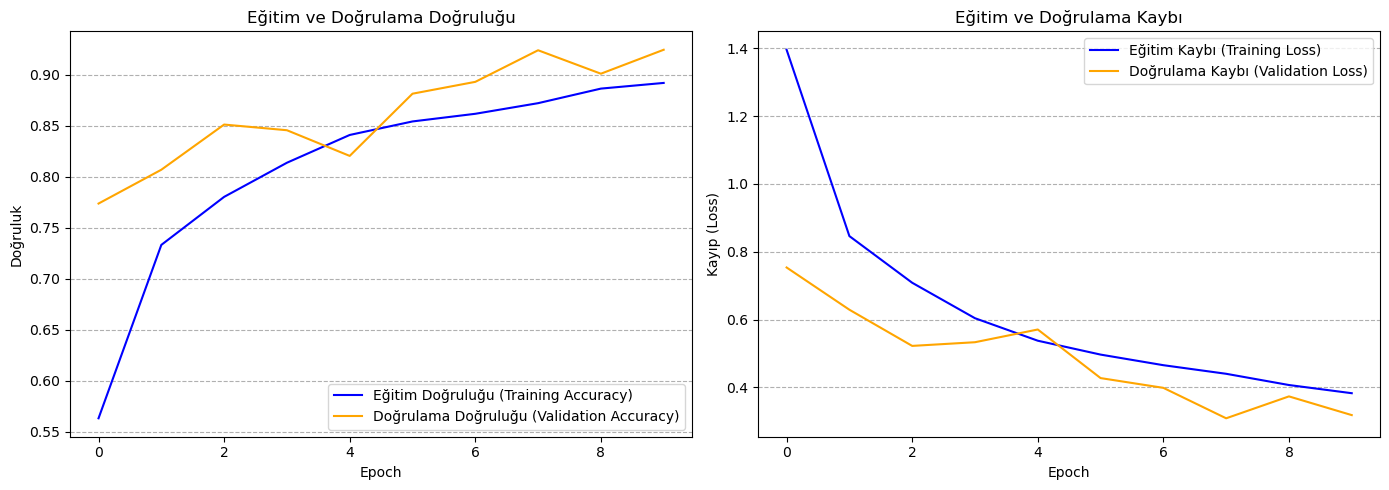

Eğitim Sonunda Elde Edilen Doğrulama Doğruluğu: 0.9247


In [20]:
# --- 1. GEREKLİ VERİLERİ ÇEKME ---

# Model.fit fonksiyonunun döndürdüğü 'history' nesnesinden değerleri alıyoruz.
# NOT: Eğer bu kodu ayrı bir Python dosyasında çalıştırıyorsanız,
# önce history nesnesini kaydetmiş olmalı ve yüklemelisiniz.
# Örneğin: history = pickle.load(open('history.pkl', 'rb'))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim yapılan toplam epoch sayısını belirleme
EPOCHS = len(acc)
epochs_range = range(EPOCHS)

print(f"\n--- HAFTA 1 SONUÇ GÖRSELLEŞTİRME ---")
print(f"Toplam eğitilen epoch sayısı: {EPOCHS}")

# --- 2. GRAFİKLERİ ÇİZME ---

plt.figure(figsize=(14, 5))

# 1. Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)', color='blue')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)', color='orange')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')

# 2. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)', color='blue')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--')

plt.tight_layout() # Grafikler arasındaki boşluğu ayarlar
plt.show()

print(f"Eğitim Sonunda Elde Edilen Doğrulama Doğruluğu: {val_acc[-1]:.4f}")

### 7. Transfer Learning

In [26]:
# Early Stopping and Model Checkpoint Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', # Doğrulama kaybını izle
    patience=5,         # Kayıp 5 epoch boyunca iyileşmezse durdur
    restore_best_weights=True
)

# For saving the best model
checkpoint_filepath = 'best_transfer_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

### 8. Feature Extraction

In [27]:
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x=base_model.output
x= GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fe = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_callback]
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6299 - loss: 1.1723

516/516 ━━━━━━━━━━━━━━━━━━━━ 637s 1s/step - accuracy: 0.7194 - loss: 0.8605 - val_accuracy: 0.8384 - val_loss: 0.4826
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8076 - loss: 0.5711

516/516 ━━━━━━━━━━━━━━━━━━━━ 285s 553ms/step - accuracy: 0.8171 - loss: 0.5458 - val_accuracy: 0.8568 - val_loss: 0.4188
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8322 - loss: 0.4975

516/516 ━━━━━━━━━━━━━━━━━━━━ 342s 663ms/step - accuracy: 0.8353 - loss: 0.4828 - val_accuracy: 0.8716 - val_loss: 0.3626
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8410 - loss: 0.4726

516/516 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.8424 - loss: 0.4650 - val_accuracy: 0.8828 - val_loss: 0.3434
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8543 - loss: 0.4262

516/516 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.8539 - loss: 0.4273 - val_accuracy: 0.8886 - val_loss: 0.3292
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 339s 658ms/step - accuracy: 0.8612 - loss: 0.4079 - val_accuracy: 0.8748 - val_loss: 0.3611
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.8675 - loss: 0.3962

516/516 ━━━━━━━━━━━━━━━━━━━━ 486s 943ms/step - accuracy: 0.8619 - loss: 0.3999 - val_accuracy: 0.8922 - val_loss: 0.3248
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 387s 750ms/step - accuracy: 0.8675 - loss: 0.3859 - val_accuracy: 0.8903 - val_loss: 0.3117
Epoch 9/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8720 - loss: 0.3786

516/516 ━━━━━━━━━━━━━━━━━━━━ 474s 919ms/step - accuracy: 0.8716 - loss: 0.3820 - val_accuracy: 0.8970 - val_loss: 0.3037
Epoch 10/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 338s 655ms/step - accuracy: 0.8774 - loss: 0.3634 - val_accuracy: 0.8949 - val_loss: 0.3047


In [31]:
# En iyi ağırlıkları geri yükle (Feature Extraction sırasında en iyi performansı vereni)
transfer_model.load_weights(checkpoint_filepath)

# 1. Temel Modeli Tekrar Çözme
base_model.trainable = True

# 2. Çözülecek Katmanları Belirleme
# Modelin başındaki ilk 100 katmanı dondurmaya devam edelim (genel özellikleri koru).
for layer in base_model.layers[:100]:
    layer.trainable = False

# 3. Çok Düşük Öğrenme Oranı ile Yeniden Derleme
# ÖNEMLİ: Öğrenme oranını 100 kat düşürmek (1e-5) modelin bozulmasını engeller.
transfer_model.compile(
    optimizer=Adam(5e-6), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Eğitim geçmişini Fine-Tuning ile birleştirmek için epoch'ları ayarla
initial_epoch_ft = len(history_fe.history['accuracy']) 
EPOCHS_FT = 10 # 10 epoch daha ince ayar yapalım
TOTAL_EPOCHS = initial_epoch_ft + EPOCHS_FT

print("\n--- İnce Ayar (Fine-Tuning) Eğitimi Başlıyor ---")
history_ft = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch_ft,
    callbacks=[early_stopping, model_checkpoint_callback]
)

# Final modeli kaydetme
transfer_model.save('final_best_transfer_model.h5')


--- İnce Ayar (Fine-Tuning) Eğitimi Başlıyor ---
Epoch 11/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 251s 464ms/step - accuracy: 0.9206 - loss: 0.2391 - val_accuracy: 0.9314 - val_loss: 0.2020
Epoch 12/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9255 - loss: 0.2205

516/516 ━━━━━━━━━━━━━━━━━━━━ 240s 466ms/step - accuracy: 0.9246 - loss: 0.2219 - val_accuracy: 0.9368 - val_loss: 0.1820
Epoch 13/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9265 - loss: 0.2233

516/516 ━━━━━━━━━━━━━━━━━━━━ 239s 464ms/step - accuracy: 0.9260 - loss: 0.2236 - val_accuracy: 0.9433 - val_loss: 0.1646
Epoch 14/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9288 - loss: 0.2200

516/516 ━━━━━━━━━━━━━━━━━━━━ 239s 463ms/step - accuracy: 0.9312 - loss: 0.2057 - val_accuracy: 0.9506 - val_loss: 0.1567
Epoch 15/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 232s 449ms/step - accuracy: 0.9280 - loss: 0.2143 - val_accuracy: 0.9450 - val_loss: 0.1708
Epoch 16/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 217s 421ms/step - accuracy: 0.9303 - loss: 0.2021 - val_accuracy: 0.9474 - val_loss: 0.1639
Epoch 17/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 217s 421ms/step - accuracy: 0.9357 - loss: 0.1979 - val_accuracy: 0.9411 - val_loss: 0.1681
Epoch 18/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 218s 422ms/step - accuracy: 0.9368 - loss: 0.1937 - val_accuracy: 0.9506 - val_loss: 0.1641
Epoch 19/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 435ms/step - accuracy: 0.9414 - loss: 0.1782 - val_accuracy: 0.9506 - val_loss: 0.1503
Epoch 20/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9449 - loss: 0.1703

516/516 ━━━━━━━━━━━━━━━━━━━━ 233s 451ms/step - accuracy: 0.9426 - loss: 0.1714 - val_accuracy: 0.9545 - val_loss: 0.1505


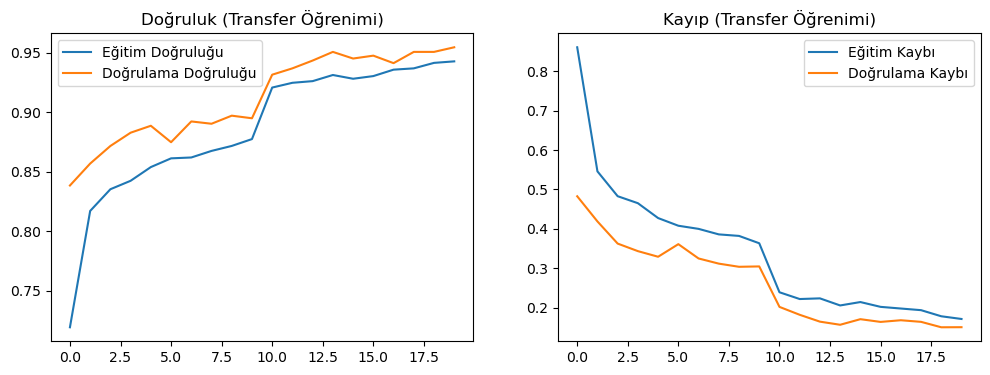


--- HAFTA 2 SONUÇ ---
Transfer Öğrenimi Son Doğrulama Doğruluğu: 0.9545


In [32]:
# İki eğitimin sonuçlarını birleştirme
acc = history_fe.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_fe.history['loss'] + history_ft.history['loss']
val_loss = history_fe.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.title('Doğruluk (Transfer Öğrenimi)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.title('Kayıp (Transfer Öğrenimi)')
plt.legend()
plt.show()

print(f"\n--- HAFTA 2 SONUÇ ---")
print(f"Transfer Öğrenimi Son Doğrulama Doğruluğu: {val_acc[-1]:.4f}")